# Reliability anaysis


## Packages and Helpers

In [13]:
# packages
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from utils import load_dataframes
from scipy.stats import pearsonr
import random
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
import pingouin as pg
import seaborn as sns

## Read Processed Data

In [14]:
# load overall df
all_data = pd.read_csv("processed_data/items_per_LLM.csv")

In [15]:
all_data.describe()

,score,score_top_n,H_score,score_expected
count,18938.000000,21192.000000,368.000000,304.000000
mean,5.090596,3.746034,0.399521,0.497405
std,9.681384,7.833186,0.114482,0.181776
min,0.002930,0.000000,0.169929,0.182070
25%,0.960015,0.929995,0.303420,0.331352
50%,1.851665,1.000000,0.395055,0.514704
75%,3.291740,3.284930,0.491583,0.646394
max,77.704271,92.000000,0.726647,0.794977


## Normalize item scores where tasks have different scales on different items
- AUDIT, FTND, GABS, PG

In [16]:
def normalize_per_scale(data):
    scales_to_normalize = ["AUDIT scale", "FTND scale", "GABS scale", "PG scale"]

    data = data.copy()

    # Loop over each experiment you want to normalize
    for scale in scales_to_normalize:
        mask = data["experiment"] == scale

        if mask.sum() == 0:
            continue  # skip if scale not present

        # Normalize score
        data.loc[mask, "score"] = (
            data.loc[mask, "score"] - data.loc[mask, "score"].min()
        ) / (data.loc[mask, "score"].max() - data.loc[mask, "score"].min())

        # Normalize score_top_n
        data.loc[mask, "score_top_n"] = (
            data.loc[mask, "score_top_n"] - data.loc[mask, "score_top_n"].min()
        ) / (data.loc[mask, "score_top_n"].max() - data.loc[mask, "score_top_n"].min())

    return data

all_data = normalize_per_scale(all_data)


In [17]:
# task_names = all_data['experiment'].unique()
# model_names = all_data["model"].unique()
# for model_name in model_names:
#     #for task_name in task_names:
#     sub_df = all_data[
#         (all_data['model'] == model_name) &
#         (all_data['experiment'] == "DFD task")
#     ]
#     print(sub_df)

## Chronbach's Alpha

In [18]:
# function:
def compute_cronbach_alpha(score = "score"):
    results = []

    # loop through experiments
    for exp, exp_data in all_data.groupby("experiment"):
        
        # check whether this experiment has subcategories
        if exp_data["category"].notna().any() and exp != "SOEP scale":
            # compute alpha per category (domain)
            for domain, domain_data in exp_data.groupby("category"):
                df_wide = domain_data.pivot_table(
                    index="model", columns="item", values=score
                )
                #print(df_wide)
                if df_wide.shape[1] > 1:
                    alpha, ci = pg.cronbach_alpha(df_wide)
                else:
                    alpha, ci = None, (None, None)
                
                results.append({
                    "experiment": exp,
                    "domain": domain,
                    "alpha": alpha,
                    "alpha_CI": ci
                })
        else:
            # compute alpha for the whole experiment
            df_wide = exp_data.pivot_table(
                index="model", columns="item", values=score
            )
            #print(exp, df_wide.std().describe())
            if df_wide.shape[1] > 1:
                alpha, ci = pg.cronbach_alpha(df_wide)
            else:
                alpha, ci = None, (None, None)
            
            results.append({
                "experiment": exp,
                "domain": "total",  # no subdomain
                "alpha": alpha,
                "alpha_CI": ci
            })

    # convert to DataFrame
    return(pd.DataFrame(results))



In [19]:
# ---- Cronbach's alpha per domain or directly per scale, depending on whether the scale has subdomains ----
alpha_df = compute_cronbach_alpha()


# ---- Cronbach's alpha per domain or directly per scale, depending on whether the scale has subdomains ----
alpha_top_n_df = compute_cronbach_alpha(score = "score_top_n")


# Merge only selected columns
alpha_df = alpha_df.merge(
    alpha_top_n_df,
    on=["experiment", "domain"],
    how="inner",
    suffixes=("_total", "_argmax")
)

display(alpha_df)

,experiment,domain,alpha_total,alpha_CI_total,alpha_argmax,alpha_CI_argmax
0,AUDIT scale,total,0.971268,"[0.957, 0.982]",0.888399,"[0.834, 0.931]"
1,BARRAT scale,BISa,0.494596,"[0.239, 0.688]",0.449631,"[0.172, 0.661]"
2,BARRAT scale,BISm,0.920164,"[0.881, 0.95]",0.853899,"[0.782, 0.909]"
3,BARRAT scale,BISn,0.417219,"[0.132, 0.638]",0.425992,"[0.145, 0.644]"
4,BART task,total,0.984716,"[0.977, 0.991]",0.984364,"[0.977, 0.99]"
5,CARE scale,CAREa,0.996488,"[0.995, 0.998]",0.998499,"[0.998, 0.999]"
6,CARE scale,CAREs,0.998416,"[0.998, 0.999]",0.998296,"[0.997, 0.999]"
7,CARE scale,CAREw,0.935888,"[0.899, 0.962]",0.993222,"[0.989, 0.996]"
8,CCT task,total,0.984565,"[0.977, 0.991]",0.978183,"[0.967, 0.987]"
9,DAST scale,total,0.977460,"[0.967, 0.986]",0.947278,"[0.922, 0.967]"


In [20]:
# df_wide = all_data[all_data["experiment"] == "SSSV scale"].pivot_table(index='model', columns='item', values='score')

# # Compute correlation between models
# correlations = df_wide.corr()
# correlations

## Split-half Reliability

In [21]:
def split_half_reliability(df_items, n_splits=100):
    """Compute average split-half reliability (Spearman-Brown corrected)."""

    k = df_items.shape[1]
    
    if k < 2:
        return None, None

    cols = df_items.columns
    results = []

    for _ in range(n_splits):
        shuffled = np.random.permutation(cols)
        half1 = shuffled[:k//2]
        half2 = shuffled[k//2:]

        s1 = df_items[half1].sum(axis=1)
        s2 = df_items[half2].sum(axis=1)

        r, _ = pearsonr(s1, s2)

        if np.isfinite(r):
            r_sb = (2 * r) / (1 + r)  # Spearman-Brown correction
            results.append(r_sb)

    if len(results) == 0:
        return None, None
    
    return np.mean(results), np.std(results)


In [22]:
def compute_split_half_reliability(score="score"):
    rows = []  # final list of results

    for exp, exp_data in all_data.groupby("experiment"):

        # case 1: experiments with domains
        if exp_data["category"].notna().any() and exp != "SOEP scale":
            for domain, domain_data in exp_data.groupby("category"):

                df_wide = domain_data.pivot_table(
                    index="model", columns="item", values=score
                )

                mean_rsb, sd_rsb = split_half_reliability(df_wide)

                rows.append({
                    "experiment": exp,
                    "domain": domain,
                    "split_half_mean": mean_rsb,
                    "split_half_sd": sd_rsb
                })

        # case 2: experiments without domains
        else:
            df_wide = exp_data.pivot_table(
                index="model", columns="item", values=score
            )

            mean_rsb, sd_rsb = split_half_reliability(df_wide)

            rows.append({
                "experiment": exp,
                "domain": "total",
                "split_half_mean": mean_rsb,
                "split_half_sd": sd_rsb
            })

    return pd.DataFrame(rows)


In [23]:
split_half_reliability = compute_split_half_reliability()
split_half_reliability

,experiment,domain,split_half_mean,split_half_sd
0,AUDIT scale,total,0.972225,0.013030
1,BARRAT scale,BISa,0.462095,0.560341
2,BARRAT scale,BISm,0.956287,0.025412
3,BARRAT scale,BISn,0.056061,1.880908
4,BART task,total,0.988710,0.004594
5,CARE scale,CAREa,0.996710,0.001314
6,CARE scale,CAREs,0.998792,0.000550
7,CARE scale,CAREw,0.951984,0.007127
8,CCT task,total,0.993926,0.003812
9,DAST scale,total,0.980927,0.007583


## Visualize Distributions per model

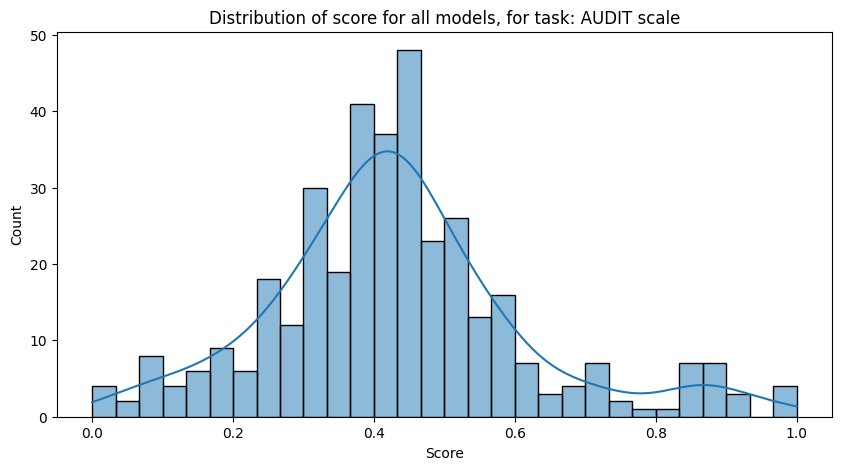

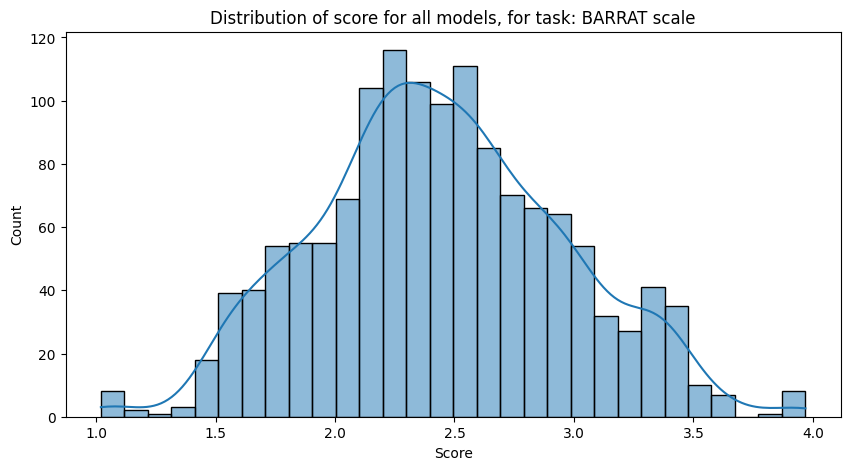

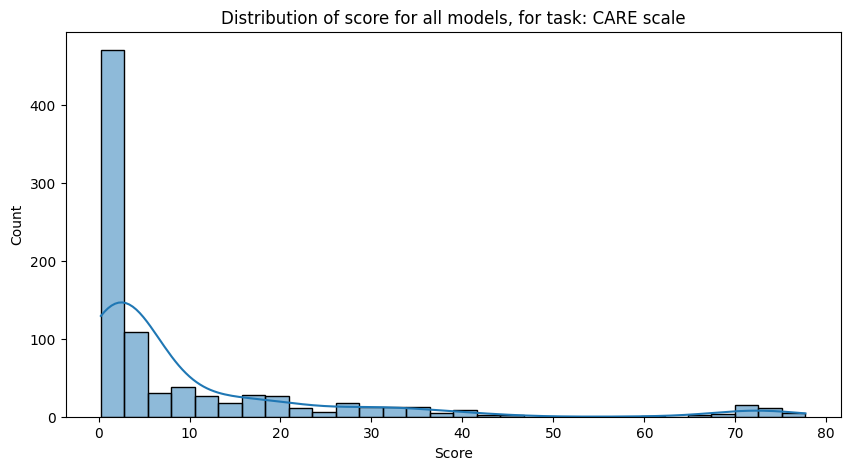

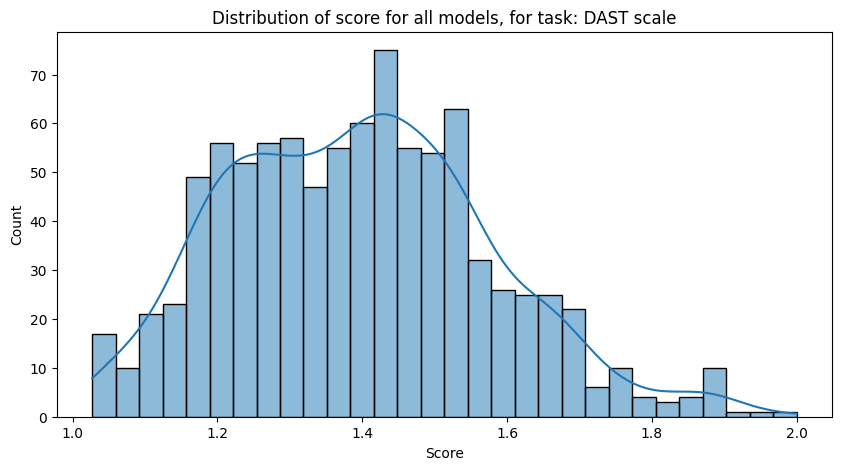

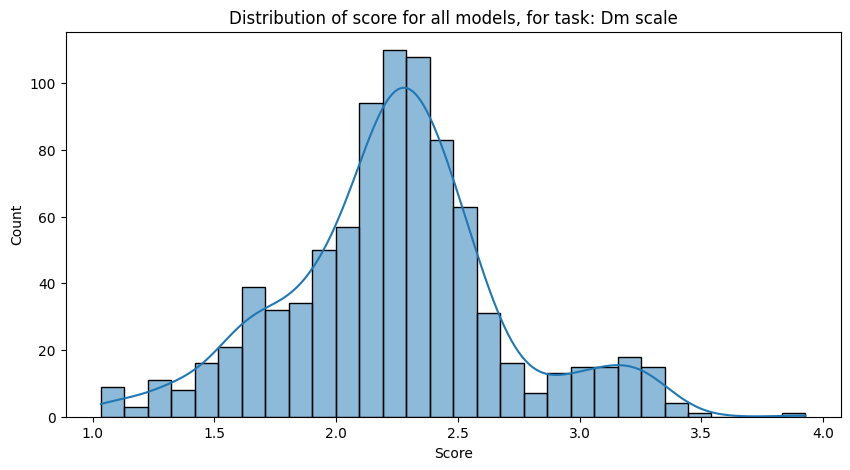

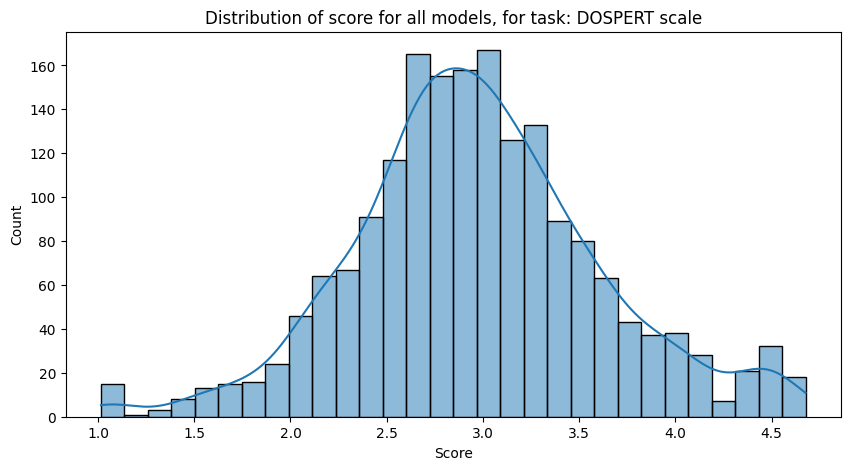

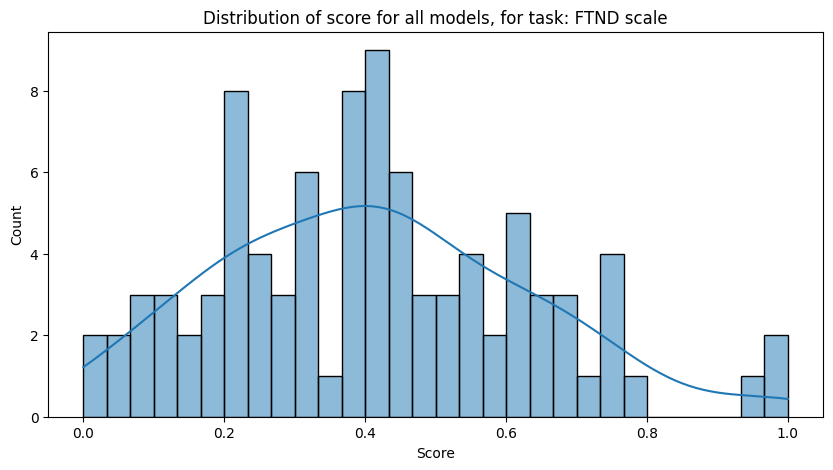

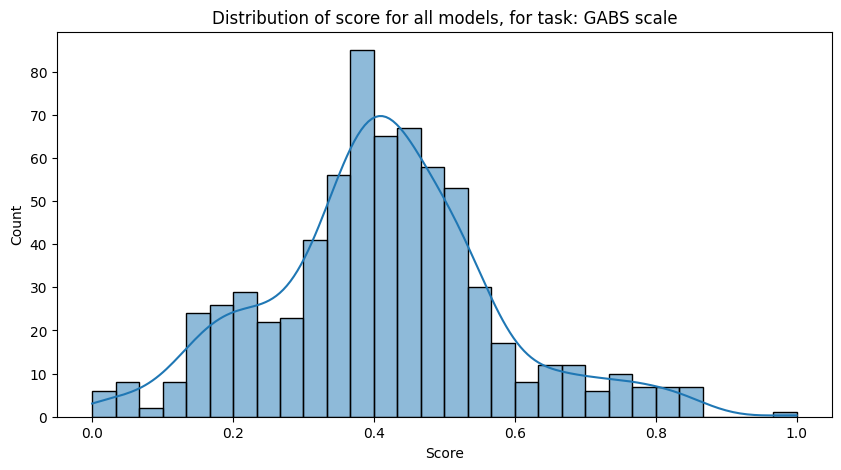

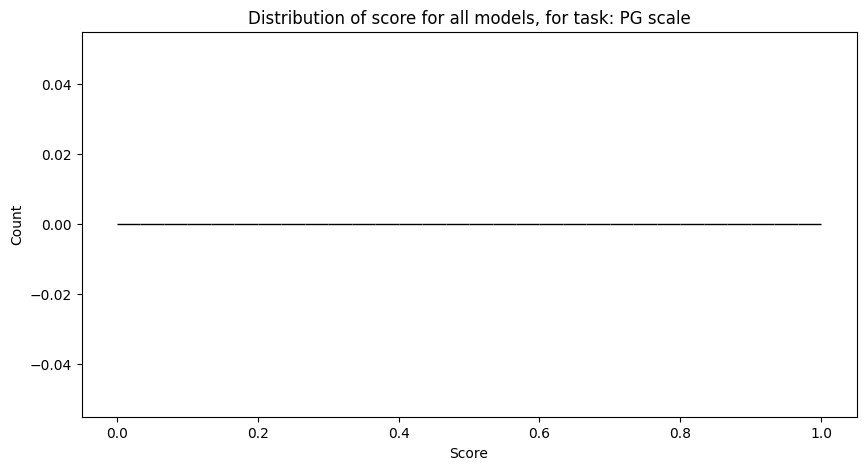

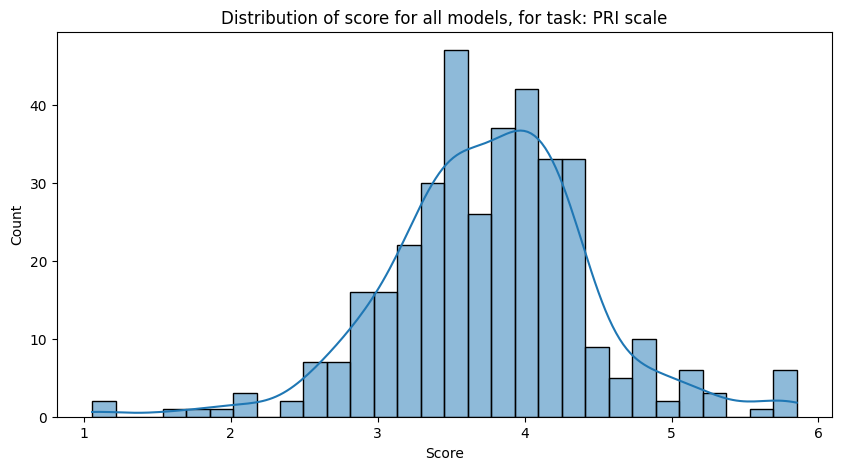

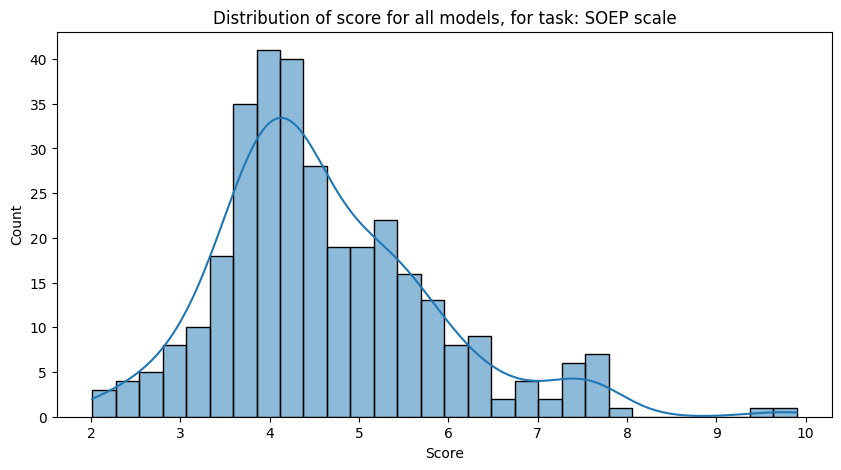

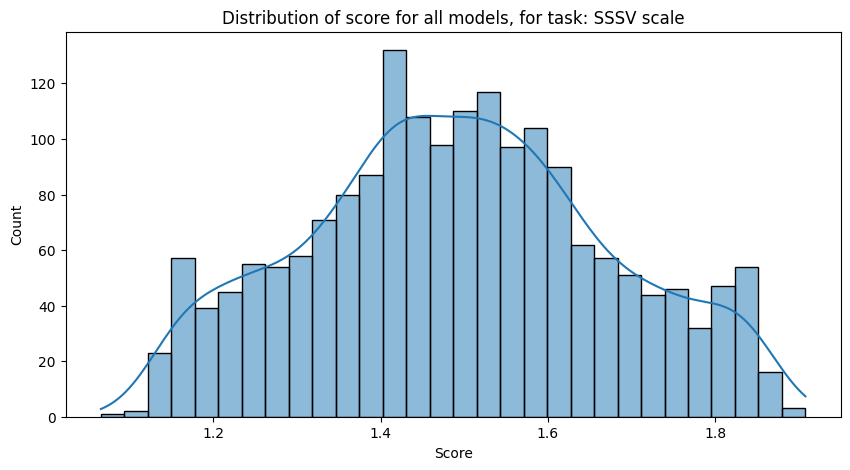

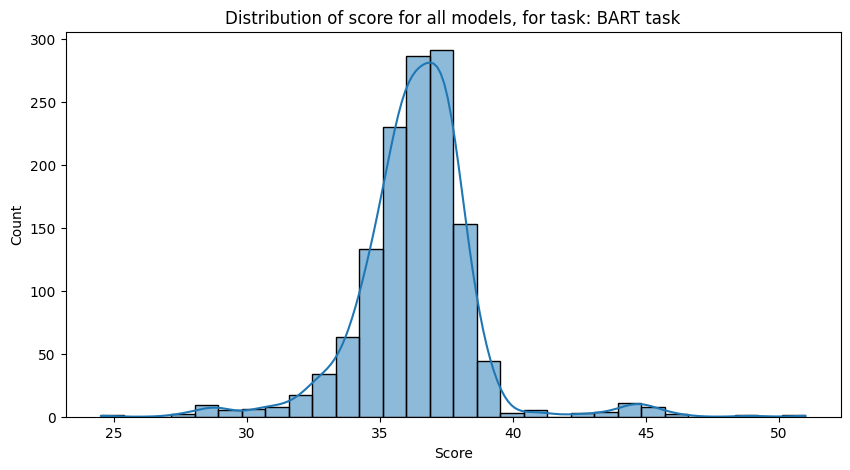

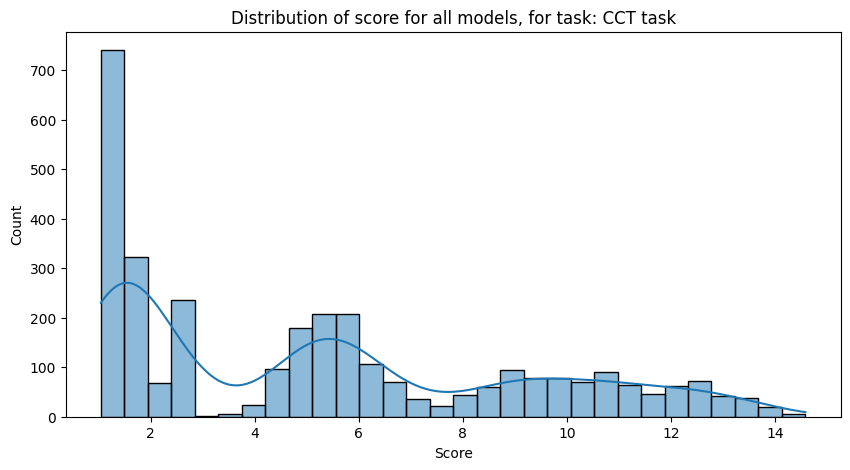

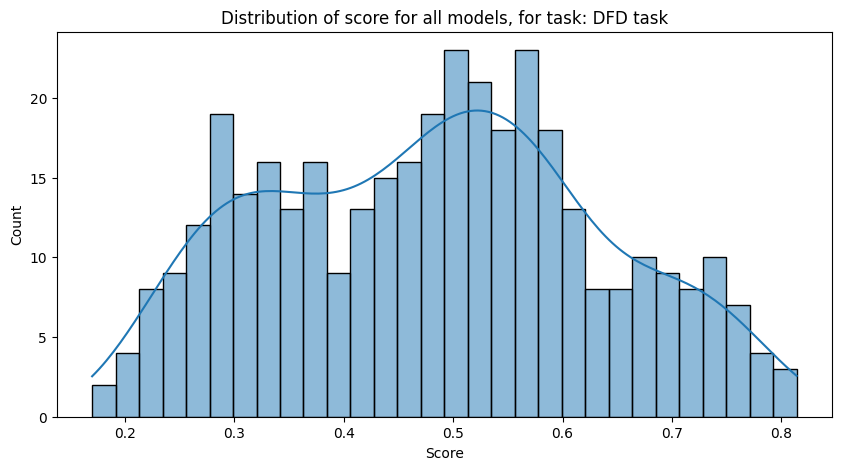

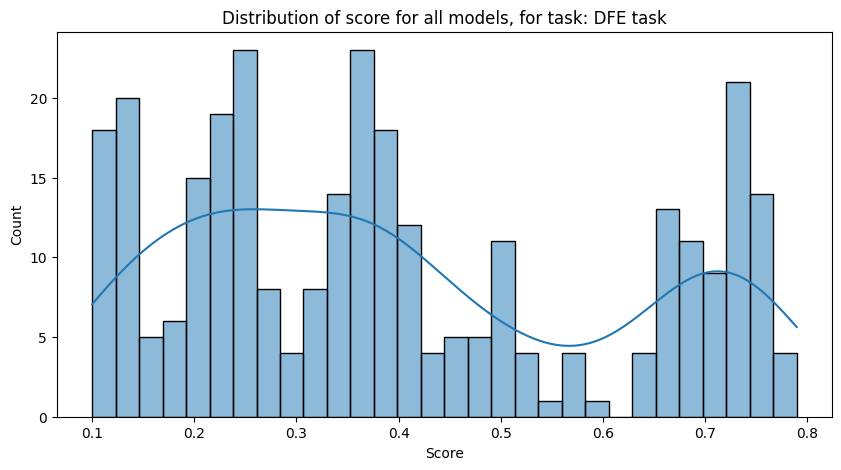

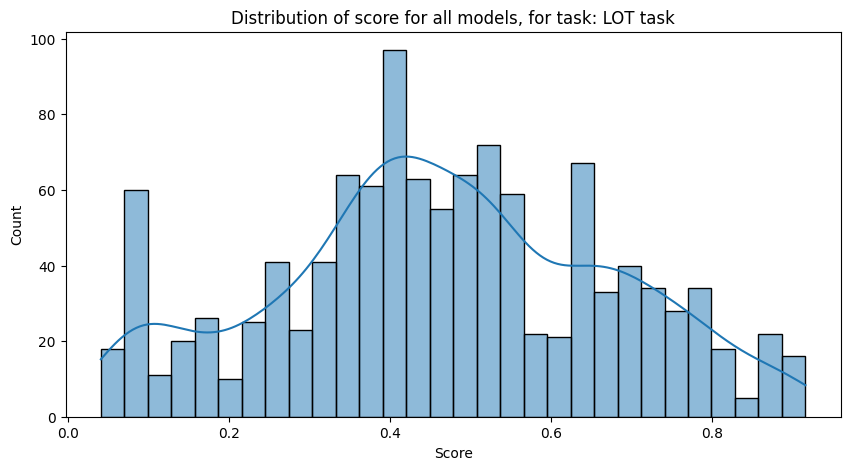

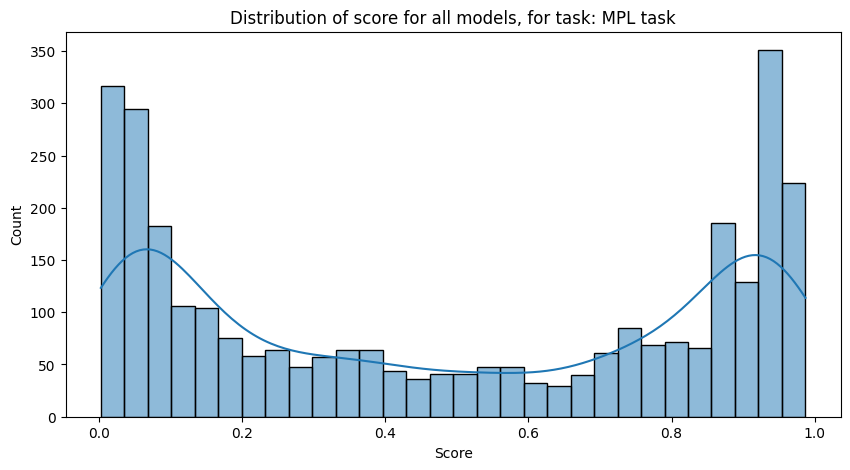

In [24]:
# Visualise distribution (focus on variance) per model of logprobs

#model_names = all_data['model'].unique()
task_names = all_data['experiment'].unique()

#for model_name in model_names:
for task_name in task_names:
    df_plot = all_data[
        #(all_data['model'] == model_name) &
        (all_data['experiment'] == task_name)
    ]
    
    plt.figure(figsize=(10, 5))
    sns.histplot(data=df_plot, x="score", kde=True, bins=30)  
    plt.title(f'Distribution of score for all models, for task: {task_name}')
    plt.xlabel('Score')
    plt.ylabel('Count')
    plt.show()